http://kylehardman.com/BlogPosts/View/6


The Deviance Information Criterion (DIC) is a way of measuring model fit for Bayesian models. It is conceptually similar to AIC and BIC. Like AIC and BIC, lower values of DIC indicate a better model fit. I will describe how to calculate DIC in the case in which unknown parameters are estimated with a Gibbs sampler, which produces samples from the posterior distribution of the parameters. DIC can be calculated with these posterior chains and some other fairly accessible information.

I have wanted to learn how to use DIC for some time, but every time I was interested, I would read the Wikipedia page on it, which I find incomprehensible, and give up. Recently, I came across a very coherent explanation of how to calculate DIC in [Bayesian Data Analysis, Third Edition](http://www.amazon.com/Bayesian-Analysis-Chapman-Statistical-Science/dp/1439840954/ref=sr_1_1?s=books&ie=UTF8&qid=1458857289&sr=1-1&keywords=bayesian+data+analysis) by Gelman, Carlin, Stern, Dunson, Vehtari, and Rubin. Along with formulas, I have added an example and a bunch of R code to make it all concrete.

I am focused on a case in which the parameters are estimated with a Gibbs sampler, so four things are required to calculate DIC:

1. The data, denoted $y$.
2. A Bayesian model for the data with some parameter vector $\theta$.
3. Samples from the posterior distribution of the parameters of the model.
4. The likelihood function, that gives the likelihood of the data given parameters, denoted $p(y|\theta)$.

I will define these things in the following sections and then show how to use them to calculate DIC.

## Data

I will illustrate how to calculate DIC with a simple example, where the data come from a normal distribution. To start with, I will sample the data, $y$, which are 50 realizations from a normal distribution with a mean of 40 and a standard deviation of 10.


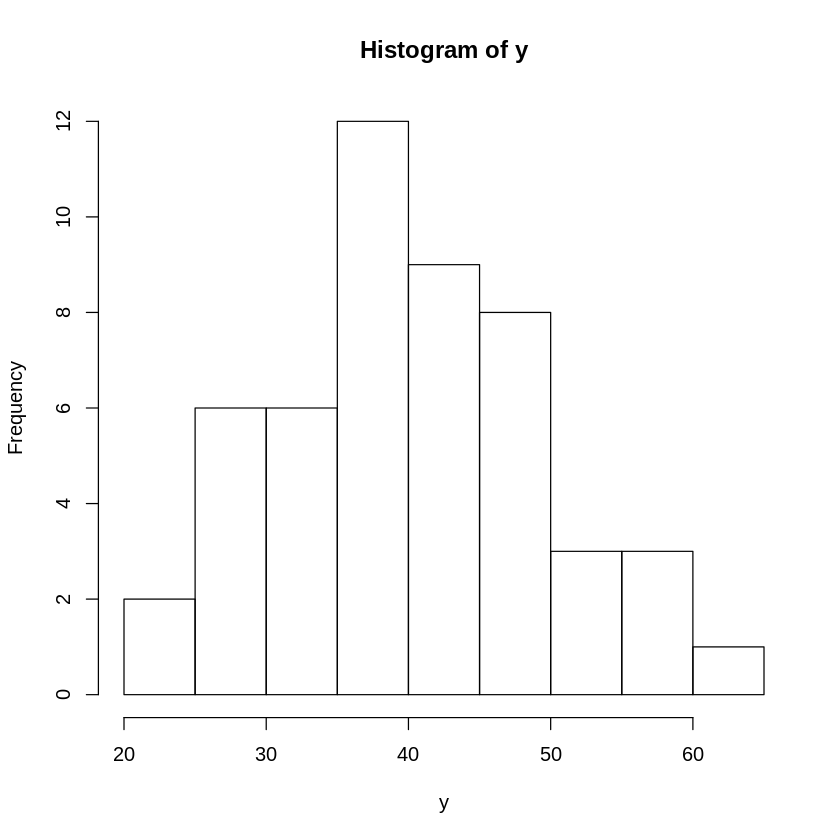

In [1]:
set.seed(123)
y = rnorm(50, 40, 10)

hist(y)


## Bayesian Model

Now I will specify a Bayesian model for this data. I will (correctly) assume that the data come from a normal distribution with unknown mean, $\mu$, and variance, $\sigma^2$.
$$
y_i \sim Normal(\mu, \sigma^2)
$$
where the priors on $\mu$ and $\sigma^2$ are
$$
\mu \sim Normal(\mu_0, \sigma_0^2) \\
\sigma^2 \sim Inverse~Gamma(a_0, b_0)
$$
With simple models of this kind, closed-form posterior distributions can sometimes be derived. However, I will instead do the more general procedure of sampling from the posterior distribution with a Gibbs sampler.

## Posterior Samples

At this point, with models and data available, I need to sample from the posterior distribution of the parameters. This will be done using a Gibbs sampler to sample from the full conditional distributions of the parameters, conditional on the other parameters of the model. It should be possible to calculate DIC regardless of the method used to sample from the posterior distribution: There is nothing special about my use of a Gibbs sampler. It is assumed that the reader has some background in Bayesian parameter estimation and that the following functions need no explanation beyond the code comments.


In [2]:

#Sample a realization from the distribution of mu given
#data (y), assumed known data variance (sigma2), prior mean (mu0), and prior variance (var0).
post_mu = function(y, sigma2, mu0, var0) {
	a = length(y) / sigma2 + 1 / var0
	b = sum(y) / sigma2 + mu0 / var0
	b = b / a
	
	rnorm(1, b, sqrt(1/a))
}

#Sample a realization from the distribution of sigma2 given
#data (y), assumed known data mean (mu), prior shape (a0), and prior rate (b0).
post_sigma2 = function(y, mu, a0, b0) {
	SSE = sum((y - mu)^2)
	
	a = a0 + length(y)/2
	b = b0 + SSE / 2
	
	r = rgamma(1, a, b)
	1/r
}

#Get a matrix of samples from the posterior distribution of mu and sigma2.
#The first column of the matrix is for mu and the second column is for sigma2.
#mu0 and var0 are priors on mu and a0 and b0 are priors on sigma2
getPosteriorSamples = function(iterations, mu0, var0, a0, b0) {
  
  iterations = iterations + 1 #add space for starting values
  mu = rep(0, iterations)
  sigma2 = rep(0, iterations)
  
  #start values
  mu[1] = 0
  sigma2[1] = 20
  
  for (i in 2:iterations) {
    mu[i] = post_mu(y, sigma2[i - 1], mu0, var0)
  
  	sigma2[i] = post_sigma2(y, mu[i], a0, b0)
  }
    
  m = cbind(mu, sigma2)
  m[-1,] #strip off starting values
}



Using `getPosteriorSamples` with the data, $y$, and some relatively uninformative settings for the priors, we can obtain posterior chains for the parameters, which are stored in `theta_post`. 

In [3]:
theta_post = getPosteriorSamples(iterations=10000, mu0=0, var0=1000, a0=0.1, b0=0.1)
theta_post[1:5,]

mu,sigma2
40.48808,85.89386
41.88349,83.09866
38.92590,97.38113
41.08069,83.82432
40.55588,79.24317


Each row of `theta_post` is one realization from the posterior distribution of $\mu$ and $\sigma^2$ and is from one iteration of the Gibbs sampler. We can see that the posterior means are quite similar to the sample statistics, which suggests that the Gibbs sampler is working reasonably well:

In [4]:
apply(theta_post, 2, mean) #Posterior means
c(mean(y), var(y)) #Sample statistics

mu   sigma2 
40.25159 88.90654

[1] 40.34404 85.72352


## Likelihood Function

The last thing needed to calculate DIC is the likelihood function. For the model I'm working with, the data follow a normal distribution. Thus, the likelihood function for the data, $y$, given a parameter vector $\theta$ is given by
$$
p(y|\theta) = p(y|\mu, \sigma^2) = \prod_i \frac{1}{\sqrt{ 2 \pi \sigma^2 }} exp(\frac{-(y_i - \mu)^2}{2\sigma^2})
$$
where $\theta = (\mu, \sigma^2)$. When calculating DIC, the likelihood function is always logged, so I will just write a log likelihood function, $log~p(y|\theta)$:

In [5]:
logLikelihood = function(y, theta) {
  #Get the individual parameters out of theta.
  mu = theta[1]
  sigma2 = theta[2]
  
  #sum of log likelihoods = log of product of likelihoods
  sum( dnorm(y, mu, sqrt(sigma2), log=TRUE) )
}

This should look kind of familiar to people who have done maximum likelihood estimation.

## Calculating DIC


At this point, everything needed to calculate DIC is available. The equation for DIC is 
$$
DIC = -2 * (L - P)
$$
where $L$ is the log likelihood of the data given the posterior means of the parameters ($\hat{\theta}$) given by
$$
L = log~p(y|\hat{\theta})
$$
$\hat{\theta}$ can be obtained by taking the mean of the posterior chains, e.g. `theta_hat = apply(theta_post, 2, mean)`.

The other term in the DIC equation is $P$, which is an estimate of the effective number of parameters in the model and is given by
$$
P = 2 * [L - \frac{1}{S} \sum_{s=1}^{S} log~p(y|\theta_s) ]
$$

where $S$ is the number of posterior samples and $\theta_s$ is the parameter vector for the $s$th sample. $\theta_s$ is just the $s$th row of `theta_post`. Thus, $P$ is twice the difference between $L$, which can be thought of as a kind of best-fit log likelihood, and the average log likelihood across all samples from the posterior distribution. 

Here is a function for calculating DIC given the data, `y`, the matrix of posterior chains, `theta_post`, and a function that calculates the log likelihood of the data given the parameter vector, `llFun`.

In [6]:
calculateDIC = function(y, theta_post, llFun) {
  #Calculate L
  theta_hat = apply(theta_post, 2, mean)
  L = llFun(y, theta_hat)

  #Calculate P
  S = nrow(theta_post) #S = number of iterations
  #Add up the log likelihoods of each iteration
  llSum = 0
  for (s in 1:S) {
    theta_s = theta_post[s,]
    llSum = llSum + llFun(y, theta_s)
  }
  P = 2 * (L - (1 / S * llSum))
  
  #Calculate DIC
  DIC = -2 * (L - P)
  
  #Return the results
  list(DIC=DIC, P=P, L=L)
}


## Results

At this point, I have written all of the functions needed to calculate DIC and am ready to examine the results from the `calculateDIC` function: 

In [7]:
calculateDIC(y, theta_post, llFun=logLikelihood)

$DIC
[1] 367.3838

$P
[1] 1.930055

$L
[1] -181.7618

Remember that $P$ is supposed to be a measure of the effective number of parameters in the model. In the model, there were 2 parameters, $\mu$ and $\sigma^2$, so it appears that $P$ is pretty accurate in this case. DIC itself cannot be interpreted without another model to compare it to, so I will make a comparison model by changing the priors. 

Note that the prior mean that I have been using is $\mu_0 = 0$, which is really wrong, given that the data are centered on 40. This has not been a problem, because the prior variance, $\sigma_0^2$, was very large, making the prior on $\mu$ uninformative. One comparison model can be constructed by having an informative prior on an incorrect $\mu$ by setting $\mu_0 = 0$ and $\sigma^2_0 = 1$.

In [8]:
theta_post_constrained = getPosteriorSamples(10000, mu0=0, var0=1, a0=0.1, b0=0.1)
apply(theta_post_constrained, 2, mean)

mu      sigma2 
   1.223845 1669.791076

As can be seen, a result of making the prior on $\mu$ more informative is that it makes the posterior mean for $\mu$ quite wrong: It should be much higher. Thus, adding this prior constraint on $\mu$ has dramatically changed how the model fits. Let's examine how this changes DIC and $P$:

In [9]:
calculateDIC(y, theta_post_constrained, logLikelihood)

$DIC
[1] 513.1292

$P
[1] 0.9356466

$L
[1] -255.6289

With the informative prior on $\mu$, $P$ is now close to 1, suggesting that the effective number of parameters has been reduced by constraining $\mu$. In addition, you can see that DIC is much higher for this more constrained model. DIC is a measure of poorness of model fit, so a higher value indicates a worse fit. We would expect that the model with an informative and incorrect prior on $\mu$ would fit worse than the model with an uninformative prior on $\mu$, which is borne out by the observed DIC values.

Finally, in these last two plots, I show what happens to DIC and $P$ as the prior variance is manipulated across a range of values. Strangely, $P$ actually becomes negative at one point. In general, $P$ becomes negative when the posterior means produce a worse model fit than the average fit of each sample from the posterior distribution. Gelman et al. suggest that $P$ may become negative when the posterior mean and mode differ. Note that although $P$ has unusual behavior when $\sigma^2_0 = 9$, DIC behaves nicely.

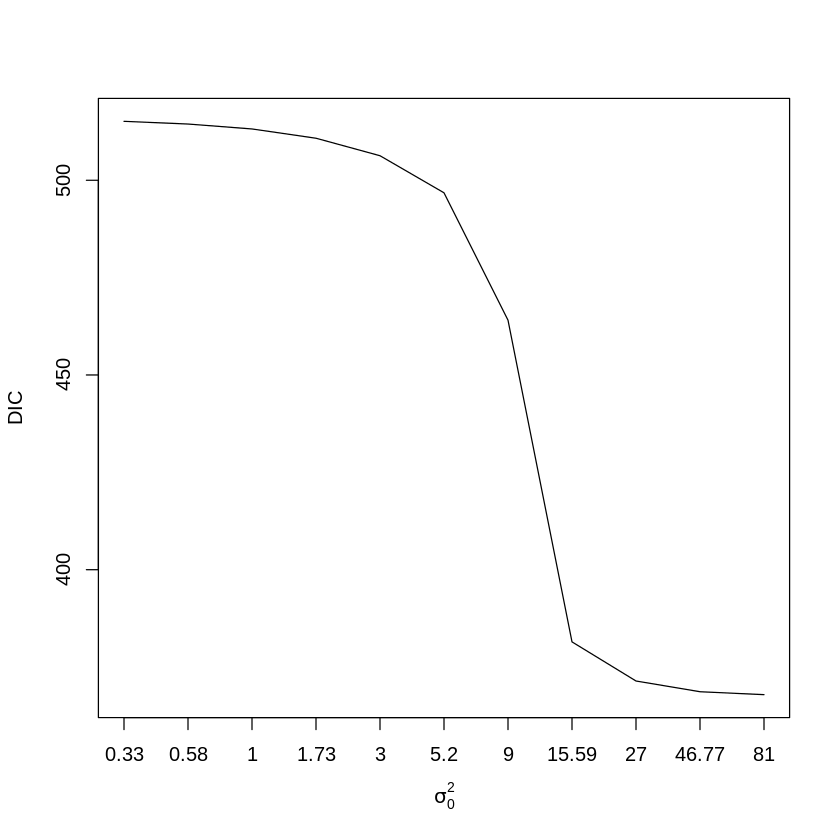

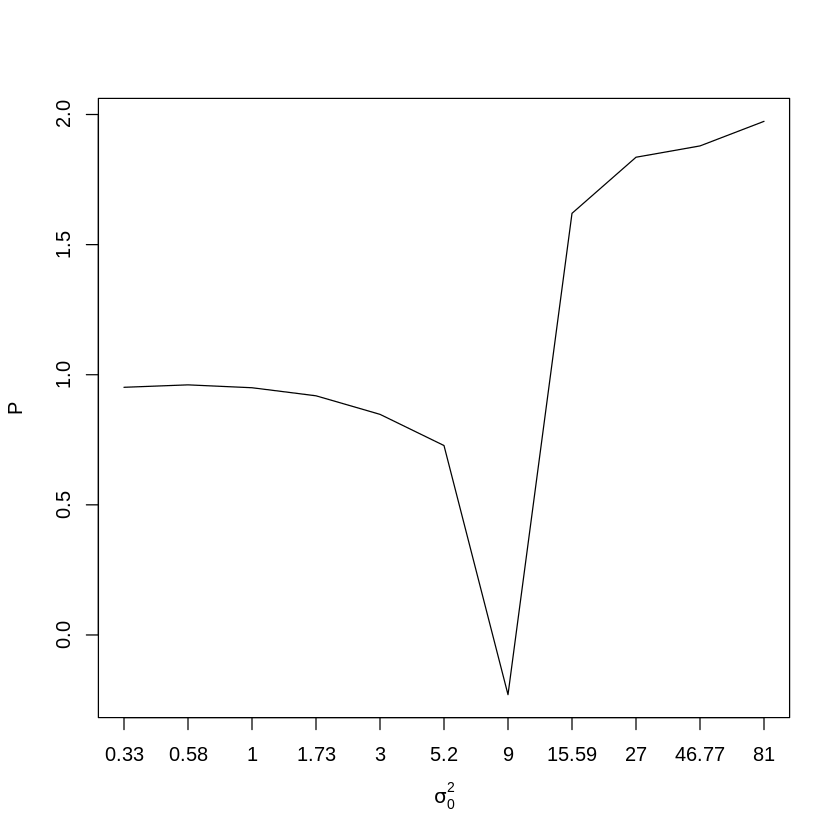

In [10]:

var0s = seq(1, 6, 0.5) - 2
var0s = 3 ^ var0s

Ps = DICs = var0s

for (i in 1:length(var0s)) {
	theta_post_constrained = getPosteriorSamples(10000, mu0=0, var0=var0s[i], a0=0.1, b0=0.1)	
	res = calculateDIC(y, theta_post_constrained, logLikelihood)
	Ps[i] = res$P
	DICs[i] = res$DIC
}

plot(DICs, axes=FALSE, type='l', xlab=bquote(sigma[0]^2), ylab="DIC")
box()
axis(2)
axis(1, at = 1:length(var0s), labels = round(var0s, 2))

plot(Ps, axes=FALSE, type='l', xlab=bquote(sigma[0]^2), ylab="P")
box()
axis(2)
axis(1, at = 1:length(var0s), labels = round(var0s, 2))




## Conclusion

DIC is a measure of model fit that can be applied to Bayesian models and that works when the parameter estimation is done using numerical techniques, such as Gibbs samplers. The calculations are not particularly difficult and the only thing needed beyond the standard output of a Gibbs sampler is the log likelihood function, which is usually straightforward to write and may even have already been programmed if a procedure like Metropolis-Hastings was used in the parameter estimation.
